# Ejemplo de identificación, estimación, diagnóstico y pronósticos de un modelo ARIMA

## Librerías


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [24]:
from scipy import stats

## Lectura de datos

Los datos corresponde al PIB de Colombia observado trimestralmente y desestacionalizado, desde el primer trimestre del año 2000 al cuarto trimestre del año 2015

In [15]:
z = pd.read_csv('../Data/PIB_real_2000_1_2015_4.txt', header=None, names=["x"])

In [18]:
len(z)

64

La serie es corta, esto puede dificultar la identiciación del proceso

In [17]:
# Agregamos columna de fechas
num_trimestres = len(z)

fechas_trimestrales = pd.date_range(start='2000-01-01', periods=num_trimestres, freq='QE')
z.index = fechas_trimestrales

print(z.head())
print()
print(z.tail())

                  x
2000-03-31  70991.0
2000-06-30  71017.0
2000-09-30  71421.0
2000-12-31  71332.0
2001-03-31  71846.0

                   x
2014-12-31  130168.0
2015-03-31  131171.0
2015-06-30  132204.0
2015-09-30  133601.0
2015-12-31  134400.0


**Análisis de estabilidad de varianza**

Es necesario usar la transformación de Box-Cox

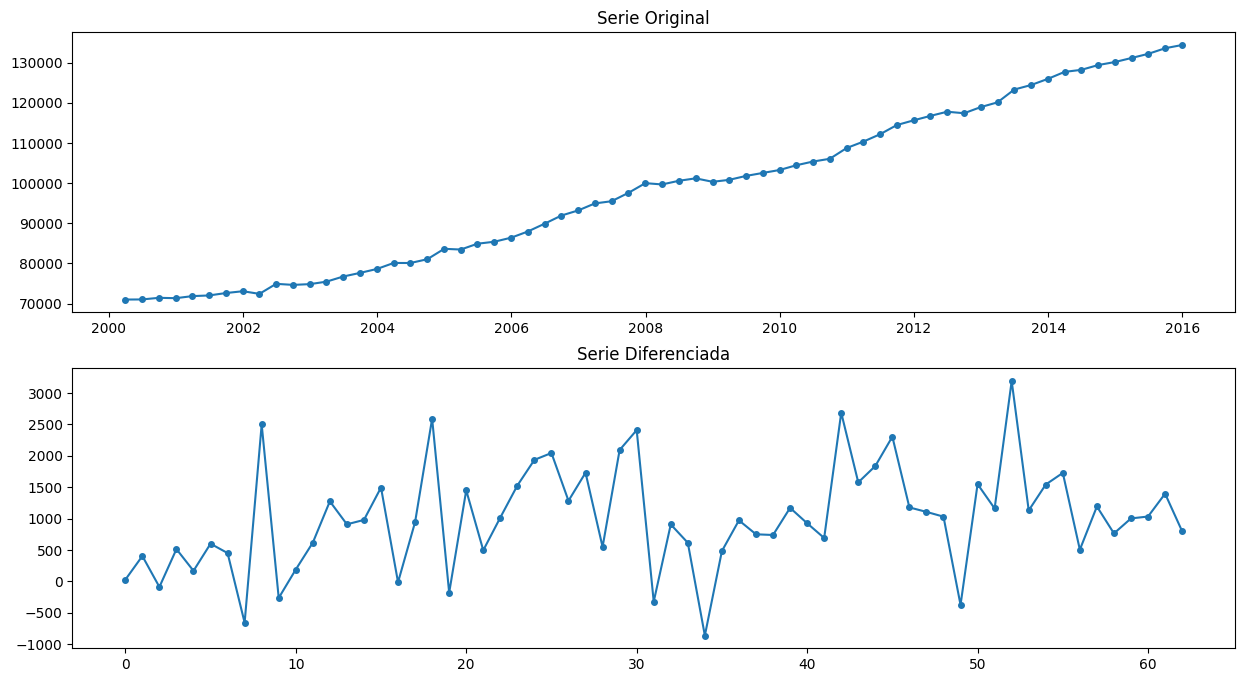

In [32]:

fig, axs = plt.subplots(2, figsize=(15,8))

axs[0].plot(z['x'], marker='o', markersize=4)
axs[0].set_title('Serie Original')

axs[1].plot(np.diff(z['x']), marker='o', markersize=4)
axs[1].set_title('Serie Diferenciada')

plt.show()

In [25]:
lambda_param = stats.boxcox_normmax(z['x'], brack=(-2,2))
print("El parámetro lambda es: ", lambda_param)

El parámetro lambda es:  0.3120891104443799


In [33]:
z_transformed, lambda_param = stats.boxcox(z['x'])
print("Parámetro lambda: ", lambda_param)

Parámetro lambda:  0.005020135456892655
